# Fitting allosteric parameters



In [1]:
%%capture
%run receptor_tools.ipynb
import numpy as np
import random
from matplotlib import pyplot as plt

#G = graphs.HouseGraph()
G = graphs.PathGraph(4)

(G, T, KappaEta, A) = enumerate_allosteric_parameters(G,method='alpha',verbose=False)
G.show(edge_labels=False)
T.show(edge_labels=True)
show(table(KappaEta))
show(A)

In [2]:
n_states=G.order()
n_kappa=n_states-1
n_kappa_plus_eta = A.ngens()
n_eta=n_kappa_plus_eta-n_kappa
kappa_list = [A.gen(k) for k in range(n_kappa)]
print(f'kappa_list = {kappa_list}')

eta_list = [A.gen(k) for k in range(n_kappa,n_kappa_plus_eta)]
print(f'eta_list = {eta_list}')

phi=normalize(random_binary_array(n_states))
print(f'phi = {phi}')

Phi = dimerize(phi)
print(f'Phi = {Phi}')
print(f'KappaEta = {KappaEta}')

kappa_list = [kappa_b, kappa_c, kappa_d]
eta_list = [eta_bb, eta_bc, eta_cc, eta_bd, eta_cd, eta_dd]
phi = [0.         0.33333333 0.33333333 0.33333333]
Phi = [[0.0, 0.0, 0.0, 0.0], [0, 0.2222222222222222, 0.1111111111111111, 0.1111111111111111], [0, 0, 0.2222222222222222, 0.1111111111111111], [0, 0, 0, 0.2222222222222222]]
KappaEta = [[1, 2*kappa_b, 2*kappa_b*kappa_c, 2*kappa_b*kappa_c*kappa_d], [0, kappa_b^2*eta_bb, 2*kappa_b^2*kappa_c*eta_bb*eta_bc, 2*kappa_b^2*kappa_c*kappa_d*eta_bb*eta_bc*eta_bd], [0, 0, kappa_b^2*kappa_c^2*eta_bb*eta_bc^2*eta_cc, 2*kappa_b^2*kappa_c^2*kappa_d*eta_bb*eta_bc^2*eta_cc*eta_bd*eta_cd], [0, 0, 0, kappa_b^2*kappa_c^2*kappa_d^2*eta_bb*eta_bc^2*eta_cc*eta_bd^2*eta_cd^2*eta_dd]]


In [3]:
# create the symbolic binding curve 
FBindingKappaEta=make_symbolic_dimer_binding_curve(Phi,KappaEta)
show(FBindingKappaEta)

(0.2222222222222222*kappa_b^2*kappa_c^2*kappa_d^2*eta_bb*eta_bc^2*eta_cc*eta_bd^2*eta_cd^2*eta_dd + 0.2222222222222222*kappa_b^2*kappa_c^2*kappa_d*eta_bb*eta_bc^2*eta_cc*eta_bd*eta_cd + 0.2222222222222222*kappa_b^2*kappa_c^2*eta_bb*eta_bc^2*eta_cc + 0.2222222222222222*kappa_b^2*kappa_c*kappa_d*eta_bb*eta_bc*eta_bd + 0.2222222222222222*kappa_b^2*kappa_c*eta_bb*eta_bc + 0.2222222222222222*kappa_b^2*eta_bb)/(kappa_b^2*kappa_c^2*kappa_d^2*eta_bb*eta_bc^2*eta_cc*eta_bd^2*eta_cd^2*eta_dd + 2.0*kappa_b^2*kappa_c^2*kappa_d*eta_bb*eta_bc^2*eta_cc*eta_bd*eta_cd + kappa_b^2*kappa_c^2*eta_bb*eta_bc^2*eta_cc + 2.0*kappa_b^2*kappa_c*kappa_d*eta_bb*eta_bc*eta_bd + 2.0*kappa_b^2*kappa_c*eta_bb*eta_bc + 2.0*kappa_b*kappa_c*kappa_d + kappa_b^2*eta_bb + 2.0*kappa_b*kappa_c + 2.0*kappa_b + 1.0)

In [4]:
# add ligand dependencies randomly or manually
manual = False
var('X')
if manual:
    d_kappa_X = dict({kappa_b: kappa_b*X, kappa_c: kappa_c*X})
else:
    def Round_To_n(x, n):
        return round(x, -int(np.floor(np.sign(x) * np.log10(abs(x)))) + n)
    d_kappa_X=dict()
    num_X = 0
    while num_X == 0: # make sure there is at least one ligand binding edge (kappa*X)
        for kappa in kappa_list:
            k=Round_To_n(np.random.exponential(scale=1.0),2)
            ligand_prob = 0.4
            if np.random.random() <= ligand_prob:
                d_kappa_X[kappa]=k*X
                num_X += 1
            else:
                d_kappa_X[kappa]=k
print(d_kappa_X)
FBindingEtaX=FBindingKappaEta.subs(d_kappa_X)
show(FBindingEtaX)

{kappa_b: 0.819*X, kappa_c: 0.12*X, kappa_d: 0.0515*X}


((5.692882759199999e-06)*X^6*eta_bb*eta_bc^2*eta_bd^2*eta_cc*eta_cd^2*eta_dd + 0.00011054141279999998*X^5*eta_bb*eta_bc^2*eta_bd*eta_cc*eta_cd + 0.0021464351999999996*X^4*eta_bb*eta_bc^2*eta_cc + 0.0009211784399999999*X^4*eta_bb*eta_bc*eta_bd + 0.017886959999999997*X^3*eta_bb*eta_bc + 0.14905799999999997*X^2*eta_bb)/((2.5617972416399995e-05)*X^6*eta_bb*eta_bc^2*eta_bd^2*eta_cc*eta_cd^2*eta_dd + 0.0009948727151999999*X^5*eta_bb*eta_bc^2*eta_bd*eta_cc*eta_cd + 0.009658958399999999*X^4*eta_bb*eta_bc^2*eta_cc + 0.00829060596*X^4*eta_bb*eta_bc*eta_bd + 0.16098263999999998*X^3*eta_bb*eta_bc + 0.01012284*X^3 + 0.6707609999999999*X^2*eta_bb + 0.19655999999999998*X^2 + 1.638*X + 1.0)

In [5]:
FastCallableFBindingEtaX = fast_callable(FBindingEtaX, vars=['X']+eta_list)

In [6]:
from scipy.optimize import minimize
import random
from matplotlib import pyplot as plt

# construct target function
# xrange and values x for data, x0 for smooth plots
xlogmin=-3
xlogmax=3
x = np.logspace(xlogmin,xlogmax,20)
x0 = np.logspace(xlogmin,xlogmax,1000)


# choose random eta's with 50% change of being 1 (unused)
eta_prob_one = 0.5
eta = np.random.exponential(scale=1.0,size=n_eta)
for i in range(n_eta):
    if np.random.random() <= eta_prob_one:
        eta[i]=1.0
y = FastCallableFBindingEtaX(x,*eta) + np.random.normal(size=x.size, scale=0.005) # w/ noise
y0 = FastCallableFBindingEtaX(x0,*eta)

In [7]:
# create hypercube and flip left/right
Q = graphs.CubeGraph(n_eta, embedding=2)
pos = Q.get_pos()
for v in Q.vertices(sort=False):
    xpos,ypos = pos[v] # do not use x,y here! These are needed below
    pos[v]=(n_eta-xpos,ypos)
    # pos[v]=(ypos,xpos) this didn't look good 
#Q.show(figsize=6,edge_labels=False,vertex_labels=True, vertex_size=100,edge_thickness=0.5,vertex_colors='white')

In [8]:
root = "1" * n_eta
d_level = dict()
for level in range(n_eta+1):
    for v in Q.vertices(sort=True):
        if level == Q.distance(v,root):
            d_level[v]=level
print(d_level)

{'111111': 0, '011111': 1, '101111': 1, '110111': 1, '111011': 1, '111101': 1, '111110': 1, '001111': 2, '010111': 2, '011011': 2, '011101': 2, '011110': 2, '100111': 2, '101011': 2, '101101': 2, '101110': 2, '110011': 2, '110101': 2, '110110': 2, '111001': 2, '111010': 2, '111100': 2, '000111': 3, '001011': 3, '001101': 3, '001110': 3, '010011': 3, '010101': 3, '010110': 3, '011001': 3, '011010': 3, '011100': 3, '100011': 3, '100101': 3, '100110': 3, '101001': 3, '101010': 3, '101100': 3, '110001': 3, '110010': 3, '110100': 3, '111000': 3, '000011': 4, '000101': 4, '000110': 4, '001001': 4, '001010': 4, '001100': 4, '010001': 4, '010010': 4, '010100': 4, '011000': 4, '100001': 4, '100010': 4, '100100': 4, '101000': 4, '110000': 4, '000001': 5, '000010': 5, '000100': 5, '001000': 5, '010000': 5, '100000': 5, '000000': 6}


In [9]:
def do_eta_fit(eta_list):

    # Define the objective function
    def objective_function(params):
        eta = params
        residuals = y - FastCallableFBindingEtaX(x,*eta)
        return np.sum(residuals ** 2)

    # Initial guess for parameters
    initial_guess = np.ones(n_eta)
    # this loop makes elements of the tuple bnds
    bnds = ()
    k = 0 # nparams
    for i in range(n_eta):
        if eta_list[i]==1.0:
            bnds += ((1, 1),) # eta = 1, not used
        else:
            bnds += ((0, None),) # eta non-negative
            k += 1

    # Perform optimization
    result = minimize(objective_function, initial_guess, bounds=bnds)

    # Extract and print optimized eta's
    optimal_eta = result.x
    np.set_printoptions(precision=2)
    print( optimal_eta )
    #print(f'{optimal_eta=}')

    # Evaluate result
    y0_result = FastCallableFBindingEtaX(x0,*optimal_eta)

    res = y - FastCallableFBindingEtaX(x,*optimal_eta)
    ssr = np.sum(res ** 2)
    n = len(y)
    aic = 2*(k+2)+n*np.log(ssr/(n-k))

    # Plot result
    plot_results = False
    if plot_results:
        plt.semilogx(x0,y0,linewidth=4,color='yellow',label='exact')
        plt.semilogx(x,y,'+',color='black',label='sim data')
        plt.semilogx(x0,y0_result,color='red',linestyle='dashed',label='fit')
        np.set_printoptions(precision=2)
        plt.title(f'aic={aic=},\ntarget eta={eta},\noptimal eta={optimal_eta}')
        plt.xlabel('x')
        plt.ylabel('phi',rotation = 0)
        plt.legend()
        plt.grid()
        plt.show()

    return aic

In [10]:
# make arcs point rightward to "lower" levels only (fewer parameters used, more 1's)
Q_directed = Q.to_directed()
for e in Q_directed.edges(sort=False):
    if d_level[e[0]]<d_level[e[1]]:
        Q_directed.delete_edge(e)
#show(Q_directed)

In [11]:
max_depth = 4
d_aic = dict();
Q_aic = copy(Q_directed)
for level in range(max_depth+1,n_eta+1): # delete levels not used
    #print(f'{max_depth=} so deleting {level=}')
    for vert, lev in d_level.items():
        if lev == level:
            Q_aic.delete_vertex(vert)
for level in range(0,max_depth+1):
    for vert, lev in d_level.items():
        if lev == level:
            if Q_aic.has_vertex(vert):
                #print(type(vert))
                aic = do_eta_fit([int(char) for char in vert])
                d_aic[vert]=str(f'{aic:.3f}')
                Q_aic.set_vertex(vert,aic)
                #print(f"level {lev} : eta_mask={vert} {aic=:.2f}")
                hang = 0
                for nv in Q_aic.neighbors_out(vert):
                    #print(f'looking at vert {vert} --> {nv}')
                    if float(d_aic[vert])>=float(d_aic[nv]): # float from str
                        #print(f'deleted edge {vert=} {d_aic[vert]=} -> {nv=} {d_aic[nv]=}')
                        Q_aic.delete_edge(vert,nv)
                    else:
                        hang+=1
                if hang==0 and vert != root:
                    Q_aic.delete_vertex(vert)

[1. 1. 1. 1. 1. 1.]
[0.77 1.   1.   1.   1.   1.  ]
[1.   0.04 1.   1.   1.   1.  ]
[1.   1.   0.03 1.   1.   1.  ]
[1.   1.   1.   0.39 1.   1.  ]
[1.   1.   1.   1.   0.35 1.  ]
[1.   1.   1.   1.   1.   0.29]


[1.   0.04 1.   1.   1.   1.  ]


[0.94 1.   0.03 1.   1.   1.  ]
[0.75 1.   1.   0.38 1.   1.  ]
[0.76 1.   1.   1.   0.35 1.  ]
[0.78 1.   1.   1.   1.   0.3 ]
[1.   0.1  0.32 1.   1.   1.  ]


[1.   0.05 1.   0.88 1.   1.  ]


[1.   0.06 1.   1.   0.83 1.  ]
[1.   0.05 1.   1.   1.   0.87]
[1.   1.   0.04 0.81 1.   1.  ]


[1.   1.   0.04 1.   0.88 1.  ]
[1.   1.   0.02 1.   1.   1.31]
[1.   1.   1.   9.56 0.06 1.  ]


[1.   1.   1.   4.05 1.   0.08]
[1.   1.   1.   1.   7.5  0.04]
[1.   0.1  0.32 1.   1.   1.  ]


[0.92 0.23 1.   0.   1.   1.  ]
[0.99 0.06 1.   1.   0.83 1.  ]
[0.99 0.05 1.   1.   1.   0.87]


[0.89 1.   0.15 0.   1.   1.  ]
[0.94 1.   0.05 1.   0.79 1.  ]


[0.94 1.   0.02 1.   1.   1.22]
[ 0.77  1.    1.   10.93  0.05  1.  ]
[0.79 1.   1.   4.36 1.   0.07]


[0.79 1.   1.   1.   7.83 0.04]


[1.00e+00 1.33e-03 5.98e-02 2.24e+02 1.00e+00 1.00e+00]
[1.   0.11 0.19 1.   1.21 1.  ]
[1.   0.11 0.19 1.   1.   1.4 ]


[1.00e+00 4.50e-03 1.00e+00 6.84e+01 2.43e-01 1.00e+00]
[1.   0.05 1.   1.1  1.   0.82]


[1.00e+00 1.59e-01 1.00e+00 1.00e+00 4.73e-03 4.87e+03]
[1.   1.   0.15 0.   0.   1.  ]
[1.   1.   0.15 0.   1.   0.  ]


[1.00e+00 1.00e+00 1.66e-01 1.00e+00 3.14e-03 9.06e+03]


[1.00e+00 1.00e+00 1.00e+00 7.32e+00 9.54e-04 2.00e+03]


[9.07e-01 2.82e-03 3.19e+03 0.00e+00 1.00e+00 1.00e+00]
[1.01 0.11 0.18 1.   1.25 1.  ]


[1.01 0.11 0.18 1.   1.   1.42]


[1.01e+00 2.62e-03 1.00e+00 1.20e+02 2.39e-01 1.00e+00]
[0.92 0.23 1.   0.   1.   0.  ]


[9.79e-01 1.66e-01 1.00e+00 1.00e+00 3.99e-03 6.46e+03]
[0.89 1.   0.15 0.   0.   1.  ]
[0.89 1.   0.15 0.   1.   0.  ]


[9.02e-01 1.00e+00 1.85e-01 1.00e+00 3.61e-03 6.08e+03]


[7.74e-01 1.00e+00 1.00e+00 7.69e+00 9.80e-04 1.83e+03]


[1.00e+00 2.00e-03 9.51e-05 1.53e+02 2.47e+01 1.00e+00]


[1.00e+00 9.78e-04 5.60e-03 3.18e+02 1.00e+00 1.02e+01]
[1.   0.11 0.17 1.   1.14 1.16]


[1.   0.05 1.   5.19 0.15 3.64]


[1.00e+00 1.00e+00 7.01e-02 5.83e-05 1.14e+02 3.95e+02]


In [12]:
print(d_aic)

{'111111': '-159.492', '011111': '-157.642', '101111': '-203.254', '110111': '-195.279', '111011': '-167.275', '111101': '-172.677', '111110': '-177.583', '001111': '-200.180', '010111': '-192.688', '011011': '-166.804', '011101': '-172.487', '011110': '-177.520', '100111': '-201.203', '101011': '-200.247', '101101': '-200.572', '101110': '-200.309', '110011': '-192.323', '110101': '-192.216', '110110': '-192.291', '111001': '-186.570', '111010': '-179.915', '111100': '-179.263', '000111': '-198.060', '001011': '-182.964', '001101': '-197.454', '001110': '-197.184', '010011': '-179.962', '010101': '-189.643', '010110': '-189.594', '011001': '-188.576', '011010': '-180.045', '011100': '-179.172', '100011': '-200.216', '100101': '-198.157', '100110': '-198.314', '101001': '-200.217', '101010': '-197.215', '101100': '-202.218', '110001': '-178.835', '110010': '-178.835', '110100': '-194.601', '111000': '-189.552', '000011': '-183.460', '000101': '-194.955', '000110': '-195.115', '001001':

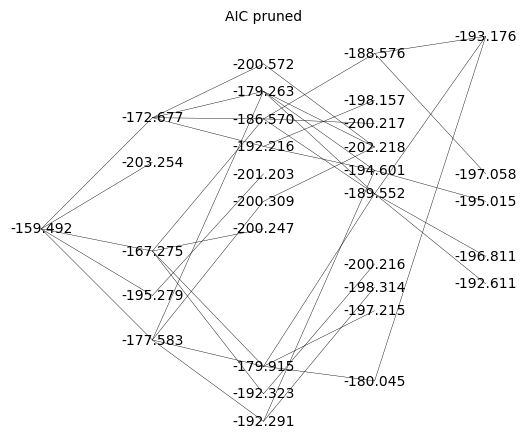

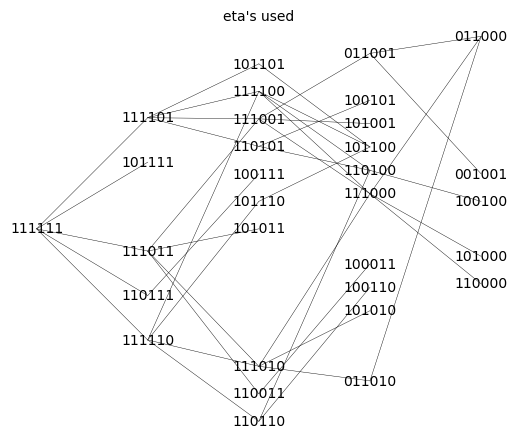

In [13]:
Q_aic_undirected = Q_aic.to_undirected()
Q_aic_undirected.show(figsize=6,edge_labels=False,vertex_labels=d_aic, vertex_size=0,edge_thickness=0.3,vertex_colors='white',title='AIC pruned')
Q_aic_undirected.show(figsize=6,edge_labels=False, vertex_size=0,edge_thickness=0.3,vertex_colors='white',title='eta\'s used')